In [34]:
import sys
sys.path.append('../')

import copy
import glob

from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample as ho_sample

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Sampler,SubsetRandomSampler

from torchmetrics import R2Score

import torch_geometric as pyg
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import InMemoryDataset
import torch_scatter
import pytorch_forecasting as pyf

from src.utils import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(17)
plt.figure(figsize=(20, 12));

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 1440x864 with 0 Axes>

In [35]:
G = nx.readwrite.read_gpickle('data/czech_road_network.p')
nx.set_node_attributes(G, {n: {'id': n} for n in G.nodes()})

In [36]:
# Pytorch geometric Data object.
pyg_data = from_networkx(G)
pyg_data.to(device);
pyg_data

Data(edge_index=[2, 2306], id=[1128], num_nodes=1128)

In [37]:
# if more than 15% of time series for a station is missed -> drop the station
intensity = pd.read_csv('data/intensity.csv')
intensity = intensity.loc[:int(len(intensity) * 0.93)]
intensity = intensity.loc[:, intensity.isna().sum() / len(intensity) < 0.15]
intensity = intensity.fillna(method='ffill')
intensity = intensity.fillna(0)
intensity.head(6)

,datetime,D00-001,D00-002,D00-003,D00-004,D00-005,D00-006,D00-007,D00-008,D00-009,...,I52-017,I55-001,I55-002,I58-010,I58-011,I58-012,I63-001,I63-002,I63-003,I63-004
0,2022-01-17 19:00:00,100,108,123,134,138,122,132.0,130,121,...,35.0,14.0,11.0,5.0,5.0,7.0,12.0,9.0,7.0,3.0
1,2022-01-17 19:15:00,118,108,123,117,115,116,128.0,126,148,...,30.0,5.0,7.0,7.0,8.0,12.0,6.0,9.0,9.0,4.0
2,2022-01-17 19:30:00,81,85,131,93,90,88,86.0,82,100,...,40.0,11.0,6.0,2.0,2.0,2.0,6.0,4.0,3.0,3.0
3,2022-01-17 19:45:00,68,70,103,87,96,103,121.0,123,124,...,43.0,8.0,7.0,2.0,2.0,4.0,15.0,10.0,10.0,8.0
4,2022-01-17 20:00:00,80,79,119,147,140,130,125.0,119,121,...,24.0,6.0,8.0,3.0,3.0,3.0,8.0,8.0,8.0,2.0
5,2022-01-17 20:15:00,87,84,79,100,102,96,105.0,116,135,...,33.0,9.0,10.0,12.0,13.0,11.0,4.0,4.0,4.0,2.0


In [38]:
nodes = intensity.columns[1:].to_list()
nodes[:5]

['D00-001', 'D00-002', 'D00-003', 'D00-004', 'D00-005']

In [39]:
avg_speed = pd.read_csv('data/avg_speed.csv')
avg_speed = avg_speed.loc[:int(len(avg_speed) * 0.93)]
avg_speed = avg_speed.fillna(method='ffill')
avg_speed = avg_speed[['datetime'] + nodes]
avg_speed = avg_speed.fillna(avg_speed.mean())
avg_speed.tail(3)

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


,datetime,D00-001,D00-002,D00-003,D00-004,D00-005,D00-006,D00-007,D00-008,D00-009,...,I52-017,I55-001,I55-002,I58-010,I58-011,I58-012,I63-001,I63-002,I63-003,I63-004
2828,2022-02-16 06:00:00,73.349998,56.610000,48.382500,85.775002,85.590000,81.684999,83.274998,71.850000,57.825001,...,65.120001,74.624998,84.844999,69.987501,85.014999,78.704998,71.392498,79.199999,79.370001,58.549999
2829,2022-02-16 06:15:00,69.877500,52.262500,52.082500,85.777500,86.189999,80.479998,82.875000,56.850001,58.615000,...,64.647499,75.977499,84.955000,62.523332,73.727498,75.133334,70.462502,82.822502,78.282499,59.530001
2830,2022-02-16 06:30:00,74.815001,59.035002,52.932499,85.897499,85.682499,81.477499,84.255001,56.000001,63.514998,...,64.337500,75.322498,82.709999,72.913333,78.326665,75.743332,71.462498,79.140001,81.825001,59.769999


In [40]:
len(nodes)

997

In [41]:
pyg_data = pyg_data.subgraph(torch.tensor([pyg_data.id.index(x) for x in nodes]))
pyg_data.id = nodes
pyg_data

Data(edge_index=[2, 2000], id=[997], num_nodes=997)

In [42]:
import itertools


class StandardScaler(nn.Module):
    def fit(self, x):
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
        
    def transform(self, x):
        x -= self.mean
        x /= (self.std + 1e-7)
        return x

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def inverse_transform(self, x):
        x *= (self.std + 1e-7)
        x += self.mean
        return x

    def to(self, device):
        super().to(device)
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)
        return self


class SnapshotTimeSeriesDataset(Dataset):
    def __init__(self, target_snapshots: pd.DataFrame,
     pyg_data: pyg.data.Data, nodes_cols, features_snapshots: List[pd.DataFrame] = None, dt_column='datetime',
      encoder_length=14, normalize=True):
        targets = target_snapshots[nodes_cols].values
        X = [targets]
        if features_snapshots is not None:
            X_feat = [feat_df[nodes_cols].values for feat_df in features_snapshots]
            X.extend(X_feat)
        # print([x.shape for x in X])
        self.X = torch.tensor(np.stack(X, axis=-1), dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32).unsqueeze(-1)

        self.pyg_data = pyg_data
        self.dts = pd.to_datetime(target_snapshots[dt_column], format='%Y-%m-%d %H:%M:%S')

        self.window = encoder_length
        self.horizon = 1
        self.period = 24 * 4

        self.make_datetime_features()

        if normalize:
            self.feature_scaler = StandardScaler()
            self.target_scaler = StandardScaler()
            self.normalize()
        
        self.make_dt_stats()

        self.shape = self.__getshape__()
        self.size = self.__getsize__()
    
    def normalize(self):
        self.X = self.feature_scaler.fit_transform(self.X)
        self.y = self.target_scaler.fit_transform(self.y)

    def make_dt_stats(self):
        tm = (self.dts.dt.hour.values * 4 + self.dts.dt.minute.values // 15)
        dt = self.dts.dt.weekday.values
        self.dts_hash = dt * 24 * 4 + tm

        tmp = np.stack([self.dts_hash, np.arange(len(self.dts_hash))]).T
        tmp = tmp[tmp[:, 0].argsort()]
        unique_stamps, index = np.unique(tmp[:, 0], return_index=True)
        indices = np.split(tmp[:, 1], index[1:])

        self.dts_stats = torch.stack([self.X[g].mean(dim=0) for g in indices])

    def make_datetime_features(self):
        """The idea here is to generate harmonic features of the time and date
        (projecting the time onto a circle and using the two coordinates).
        
        The period here follows from the fact we are using 15 min interval between 2 consequential snapshots.
        The total number of obtained features is 5.
        """
        weekday = self.dts.dt.weekday.values
        is_weekend = (self.dts.dt.weekday > 4).values[:, None]
        dt = weekday * 2 * np.pi / 7.0
        dt_harmonic = np.stack([np.cos(dt), np.sin(dt)], axis=-1)
        tm = (self.dts.dt.hour.values * 4 + self.dts.dt.minute.values // 15)
        tm = tm * 2 * np.pi / self.period 
        tm_harmonic = np.stack([np.cos(tm), np.sin(tm)], axis=-1)
        
        self.dt_feats = torch.tensor(np.hstack([dt_harmonic, tm_harmonic, is_weekend]), dtype=torch.float32)

    def __getitem__(self, index):
        """Returns temporal nodes features, temporal snapshot features (only datetime yet), targets and edge_index

        N - number of nodes
        F - number of features, usually 1 (as target)
        T - number of snapshot features
        E - edges count
        W - encoder length

        Args:
            index (int): index

        Returns:
            Tuple(X[W, N, F], SX[W, T], y[N, 1], edge_index[2, E])
        """
        X = self.X[index: index + self.window]
        
        next_stamp_stats = self.dts_stats[self.dts_hash[index + self.window: index + self.window + self.horizon]]
        stats = next_stamp_stats.squeeze(0)

        y = self.y[index + self.window: index + self.window + self.horizon].squeeze(0)
        dt_feats = self.dt_feats[index: index + self.window]

        return X, dt_feats, y, self.pyg_data.edge_index, stats

    def total_obs(self):
        return len(self.X)

    def __len__(self):
        return len(self.X) - self.window - self.horizon + 1
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

In [43]:
dataset = SnapshotTimeSeriesDataset(intensity, pyg_data, nodes, 
    features_snapshots=[avg_speed], encoder_length=96, normalize=False)
# dataset = SnapshotTimeSeriesDataset(intensity, pyg_data, nodes, encoder_length=96, normalize=False)
shapes = [x.shape for x in dataset[0]]
assert shapes[0][0] == 96 and shapes[0][1] == len(nodes)
assert shapes[1][0] == 96
assert shapes[2][0] == len(nodes) and shapes[2][1] == 1
shapes

[torch.Size([96, 997, 2]),
 torch.Size([96, 5]),
 torch.Size([997, 1]),
 torch.Size([2, 2000]),
 torch.Size([997, 2])]

In [44]:
from typing import Iterator, Iterable, Optional, Sequence, List, TypeVar, Generic, Sized, Union

class SubsetSampler(Sampler[int]):
    r"""Samples elements from a given list of indices, without replacement.

    Args:
        indices (sequence): a sequence of indices
    """
    indices: Sequence[int]

    def __init__(self, indices: Sequence[int]) -> None:
        self.indices = indices

    def __iter__(self) -> Iterator[int]:
        for x in self.indices:
            yield x

    def __len__(self) -> int:
        return len(self.indices)

def make_dataloaders(ds, batch_size=32, **kwargs):
    total_obs = ds.total_obs()
    indices = list(range(total_obs))
    train_indices = indices[:int(total_obs * 0.6) - ds.window - ds.horizon + 1]
    val_indices = indices[int(total_obs * 0.6): int(total_obs * 0.8) - ds.window - ds.horizon + 1]
    test_indices = indices[int(total_obs * 0.8): len(ds)]
    # train_indices = indices[:int(len(ds) * 0.7)]
    # val_indices = indices[int(len(ds) * 0.7): int(len(ds) * 0.85)]
    # test_indices = indices[int(len(ds) * 0.8): len(ds)]

    train_loader = DataLoader(ds, sampler=SubsetRandomSampler(train_indices), batch_size=batch_size)
    val_loader = DataLoader(ds, sampler=SubsetSampler(val_indices), batch_size=batch_size)
    test_loader = DataLoader(ds, sampler=SubsetSampler(test_indices), batch_size=batch_size)

    return train_loader, val_loader, test_loader

In [45]:
# ds = SnapshotTimeSeriesDataset(intensity, pyg_data, nodes, features_snapshots=[avg_speed], encoder_length=24)
ds = SnapshotTimeSeriesDataset(intensity, pyg_data, nodes, encoder_length=4, normalize=True)
train_loader, val_loader, test_loader = make_dataloaders(ds, batch_size=16)

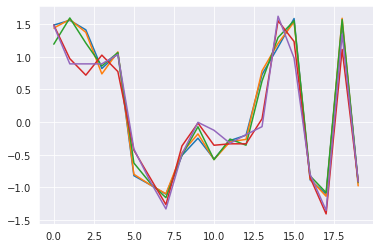

In [46]:
# Visualize 5 nodes from test dataset
batch = next(iter(train_loader))
plt.plot(np.vstack([batch[0][0, :, :5, 0].detach().numpy(), batch[2][:, :5, 0].detach().numpy()]))
plt.show()

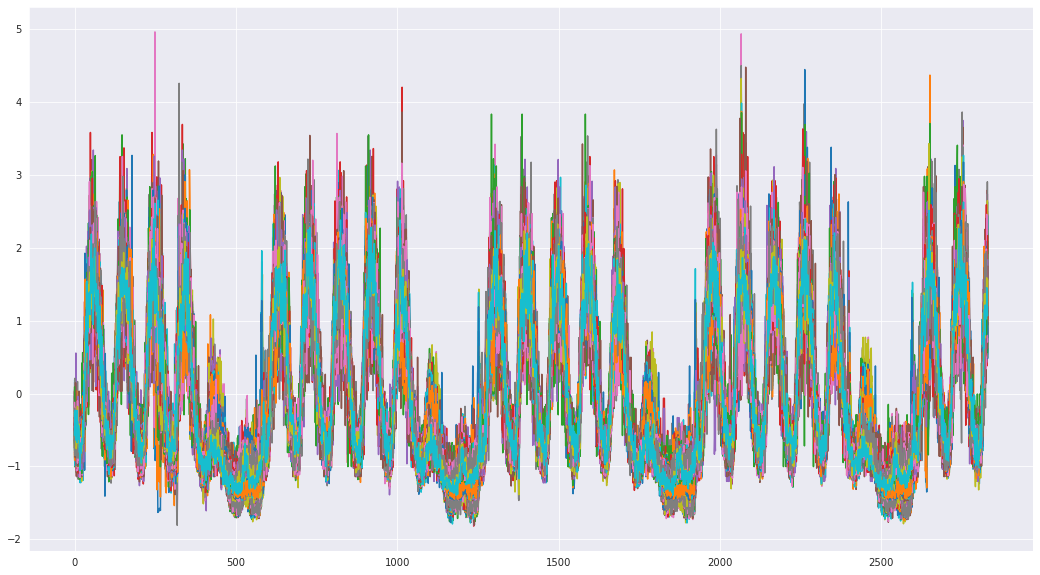

In [47]:
plt.figure(figsize=(18, 10))
plt.plot(ds.y[:, :200].squeeze().detach().cpu())
plt.show();

In [48]:
from statistics import mean
        

def test(model, loader, loss_fn, score_fn, device) -> Tuple[float, float]:
    """ returns average loss and score
    """
    model.eval()

    losses = []

    outs, ys = [], []
    with torch.no_grad():
        for X, X_extra, y, edge_index, _ in loader:
            X_gpu, X_extra_gpu, y_gpu = X.to(device), X_extra.to(device), y.to(device)
            out = model(X_gpu, edge_index=edge_index, X_extra=X_extra_gpu)

            outs.append(out)
            ys.append(y_gpu)
            loss = loss_fn(out, y_gpu)
            losses.append(loss.item())
    
    ys = torch.vstack(ys)
    outs = torch.vstack(outs)
    
    day_scores = [score_fn(outs[day: day+1], ys[day: day+1]).item() for day in range(len(ys))]
    return mean(losses), mean(day_scores)


def train(model, train_loader, val_loader,
    loss_fn, score_fn, optimizer, device, scheduler=None, num_epochs=10, plot=True, plot_update_freq=5):
    """ returns best model on validation
    """

    train_losses = []
    val_losses = []
    val_scores = []

    best_val_score = -torch.inf
    best_model = None

    for epoch in range(num_epochs + 1):
        model.train()
        losses = []
        for X, X_extra, y, edge_index, _ in train_loader:
            optimizer.zero_grad()
            X_gpu, X_extra_gpu, y_gpu = X.to(device), X_extra.to(device), y.to(device)
            out = model(X_gpu, edge_index=edge_index, X_extra=X_extra_gpu)
            loss = loss_fn(out, y_gpu)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            
        if scheduler is not None:
            scheduler.step()
        
        train_losses.append(mean(losses))
        val_loss, val_score = test(model, val_loader, loss_fn, score_fn, device)
        val_losses.append(val_loss)
        val_scores.append(val_score)

        if val_score > best_val_score:
            best_val_score = val_score
            best_model = copy.deepcopy(model)

        if plot and epoch > 0 and epoch % plot_update_freq == 0:
            clear_output(True)
            _, axes = plt.subplots(1, 2, figsize=(20, 6))
            
            sns.lineplot(ax=axes[0], x=range(epoch + 1), y=train_losses, label='Train', color='blue')
            sns.lineplot(ax=axes[0], x=range(epoch + 1), y=val_losses, label='Val', color='red')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()

            sns.lineplot(ax=axes[1], x=range(epoch + 1), y=val_scores, label='Val', color='red')
            # sns.lineplot(ax=axes[1], x=range(epoch + 1), y=train_scores, label='Train', color='blue')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Score')
            axes[1].legend()

            plt.show()
    
        # print(f'Epoch {epoch}, Loss: {train_losses[-1]:.4f}, Val loss: {val_loss:.4f}, Val R2: {val_scores[-1]:.4f}')
    return best_model

In [49]:
class MeanValueModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.param = nn.Parameter(torch.rand(1))
    
    def forward(self, X, *args):
        # print(X.shape)
        out = torch.mean(X, dim=1)[:, :, 0]
        return out

class LastValueModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.param = nn.Parameter(torch.rand(1))
    
    def forward(self, X, *args):
        out = X[:, -1, :, 0]
        return out

# for day value prediction only
class PreviousWeekValueModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.param = nn.Parameter(torch.rand(1))
    
    def forward(self, X):
        out = X[:, -7, :, 0]
        return out

In [50]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [51]:
# Train proccess runs with scaled targets (RNNs are very data demanding), 
# thus before counting score it needs unscaling targets
# to get score on the original data.
class UnscaledScore():
    def __init__(self, score_fn, scaler) -> None:
        self.score_fn = score_fn
        self.scaler = scaler
    def __call__(self, y_pred, y_true):
        y_pred = self.scaler.inverse_transform(y_pred)
        y_true = self.scaler.inverse_transform(y_true)
        res = self.score_fn(y_pred.reshape(-1), y_true.reshape(-1))
        # res *= res > 0
        return res

In [52]:
loss_fn = nn.MSELoss().to(device)
scaler = copy.deepcopy(ds.target_scaler).to(device)
score_fn = UnscaledScore(R2Score().to(device), scaler)
# score_fn = R2Score().to(device)
# score_fn = RMSELoss().to(device)
# score_fn = UnscaledScore(RMSELoss().to(device), scaler)

# Using last 6 hours to predict value in the next 15 minutes
def run(model, results, *args, **kwargs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.8)
        
    model = train(model, train_loader, val_loader,
        loss_fn, score_fn, optimizer, device, *args, **kwargs)

    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

    test_loss, test_score = test(model, test_loader, loss_fn, score_fn, device)

    # for name, param in model.named_parameters():
        # print(name, param)

    if test_score is not torch.nan:
        results[f'{model.__class__.__name__}'] = test_score
    print(f'Type: {model.__class__.__name__}, Test loss: {test_loss:.2f}, Test score: {test_score:.4f}')

    return model

In [53]:
import random

def evaluate_plot(model, loader, scaler, nodes_ids=nodes, nodes_num=5):
    outs, ys = [], []
    fig, axes = plt.subplots(nodes_num, figsize=(20, nodes_num * 6))
    
    with torch.no_grad():
        for X, X_extra, y, edge_index, _ in loader:
            X_gpu, X_extra_gpu, y_gpu = X.to(device), X_extra.to(device), y.to(device)
            out = model(X_gpu, edge_index=edge_index, X_extra=X_extra_gpu)

            outs.append(out)
            ys.append(y_gpu)
        
        # ys = torch.vstack(ys).detach().cpu().numpy()
        # outs = torch.vstack(outs).detach().cpu().numpy()
        # print(ys.shape)
        # fukc()
        ys = scaler.inverse_transform(torch.vstack(ys)).detach().cpu().numpy()
        outs = scaler.inverse_transform(torch.vstack(outs)).detach().cpu().numpy()

        for idx, node in enumerate(random.choices(range(len(nodes_ids)), k=nodes_num)):
            axes[idx].set_title(nodes_ids[node])
            # axes[idx].plot(ds.y[test_loader.sampler.indices, node], label='actual', c='r')
            axes[idx].plot(ys[:, node, 0], label='actual', c='r')
            axes[idx].plot(outs[:, node, 0], label='pred', c='b')
            axes[idx].legend()
        plt.show()

In [54]:
results = {}

**Linear Model**

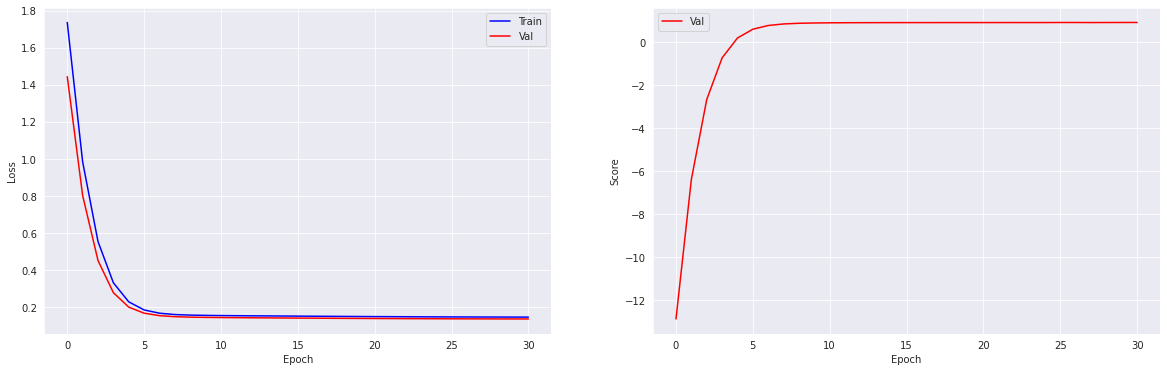

Type: LinearModel, Test loss: 0.13, Test score: 0.8964


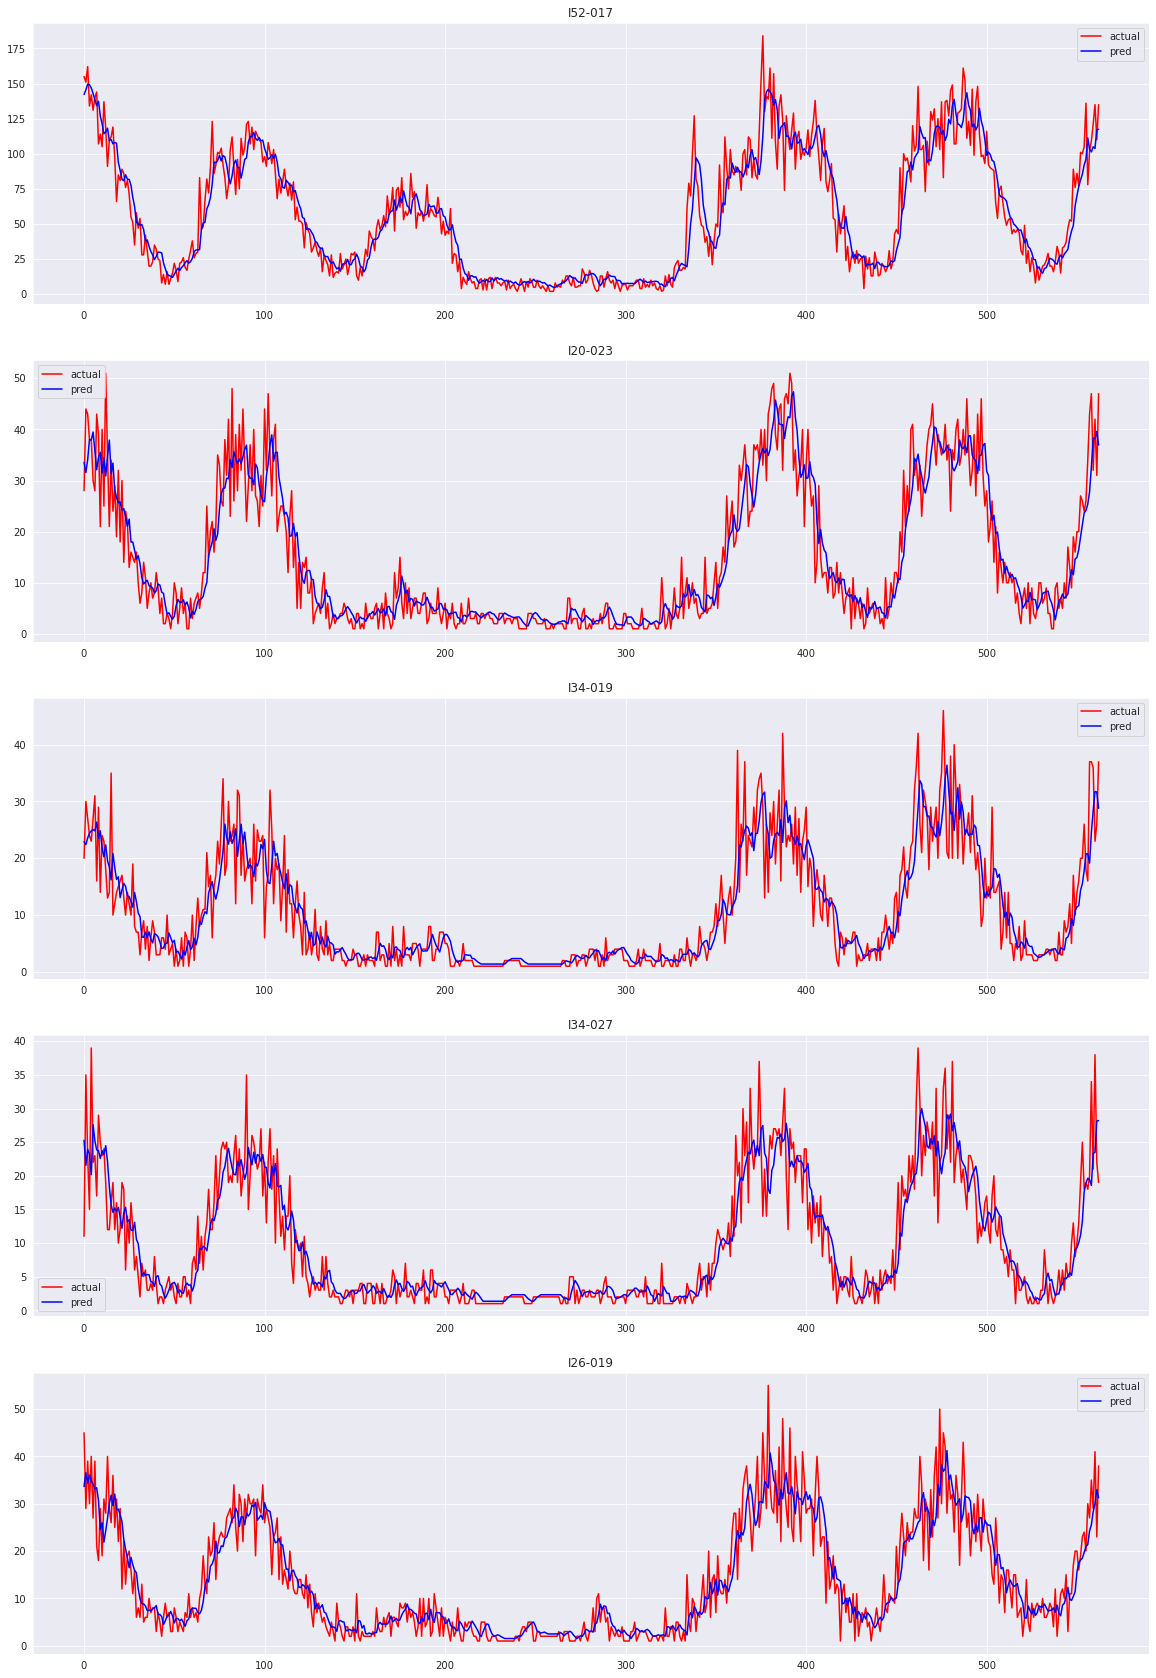

In [55]:
class LinearModel(nn.Module):
    def __init__(self, encoder_length=14, in_channels=1, out_channels=1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.window = encoder_length
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = nn.Linear(self.window * self.in_channels, self.out_channels)
    
    def forward(self, X, *args, **kwargs):
        X = X.transpose(1, 2)
        batch_size = X.shape[0]
        nodes_num = X.shape[1]
        X = X.reshape(batch_size, nodes_num, -1)
        
        out = self.lin(X)
        return out

model = LinearModel(encoder_length=4, in_channels=1).to(device)
model = run(model, results, num_epochs=30, plot=True, plot_update_freq=5)
evaluate_plot(model, test_loader, scaler)

**LSTM**

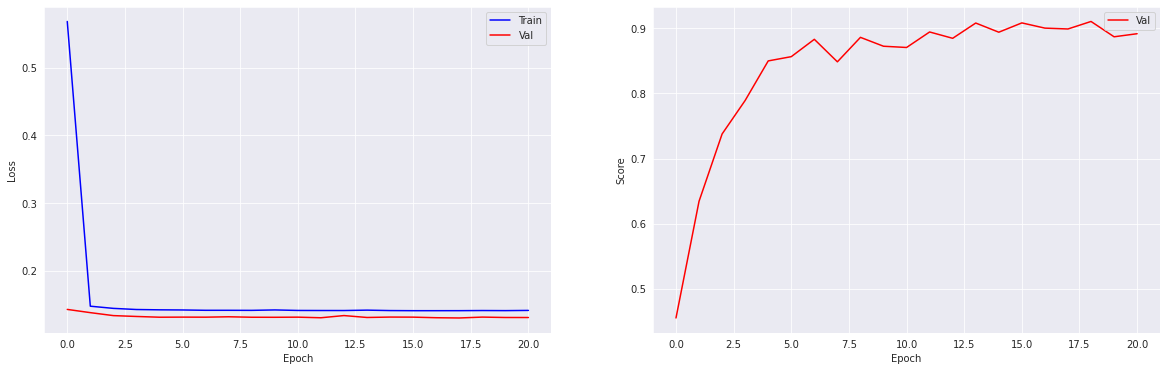

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/torch/nn/modules/rnn.py:762: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Type: LSTM_Model, Test loss: 0.13, Test score: 0.9068


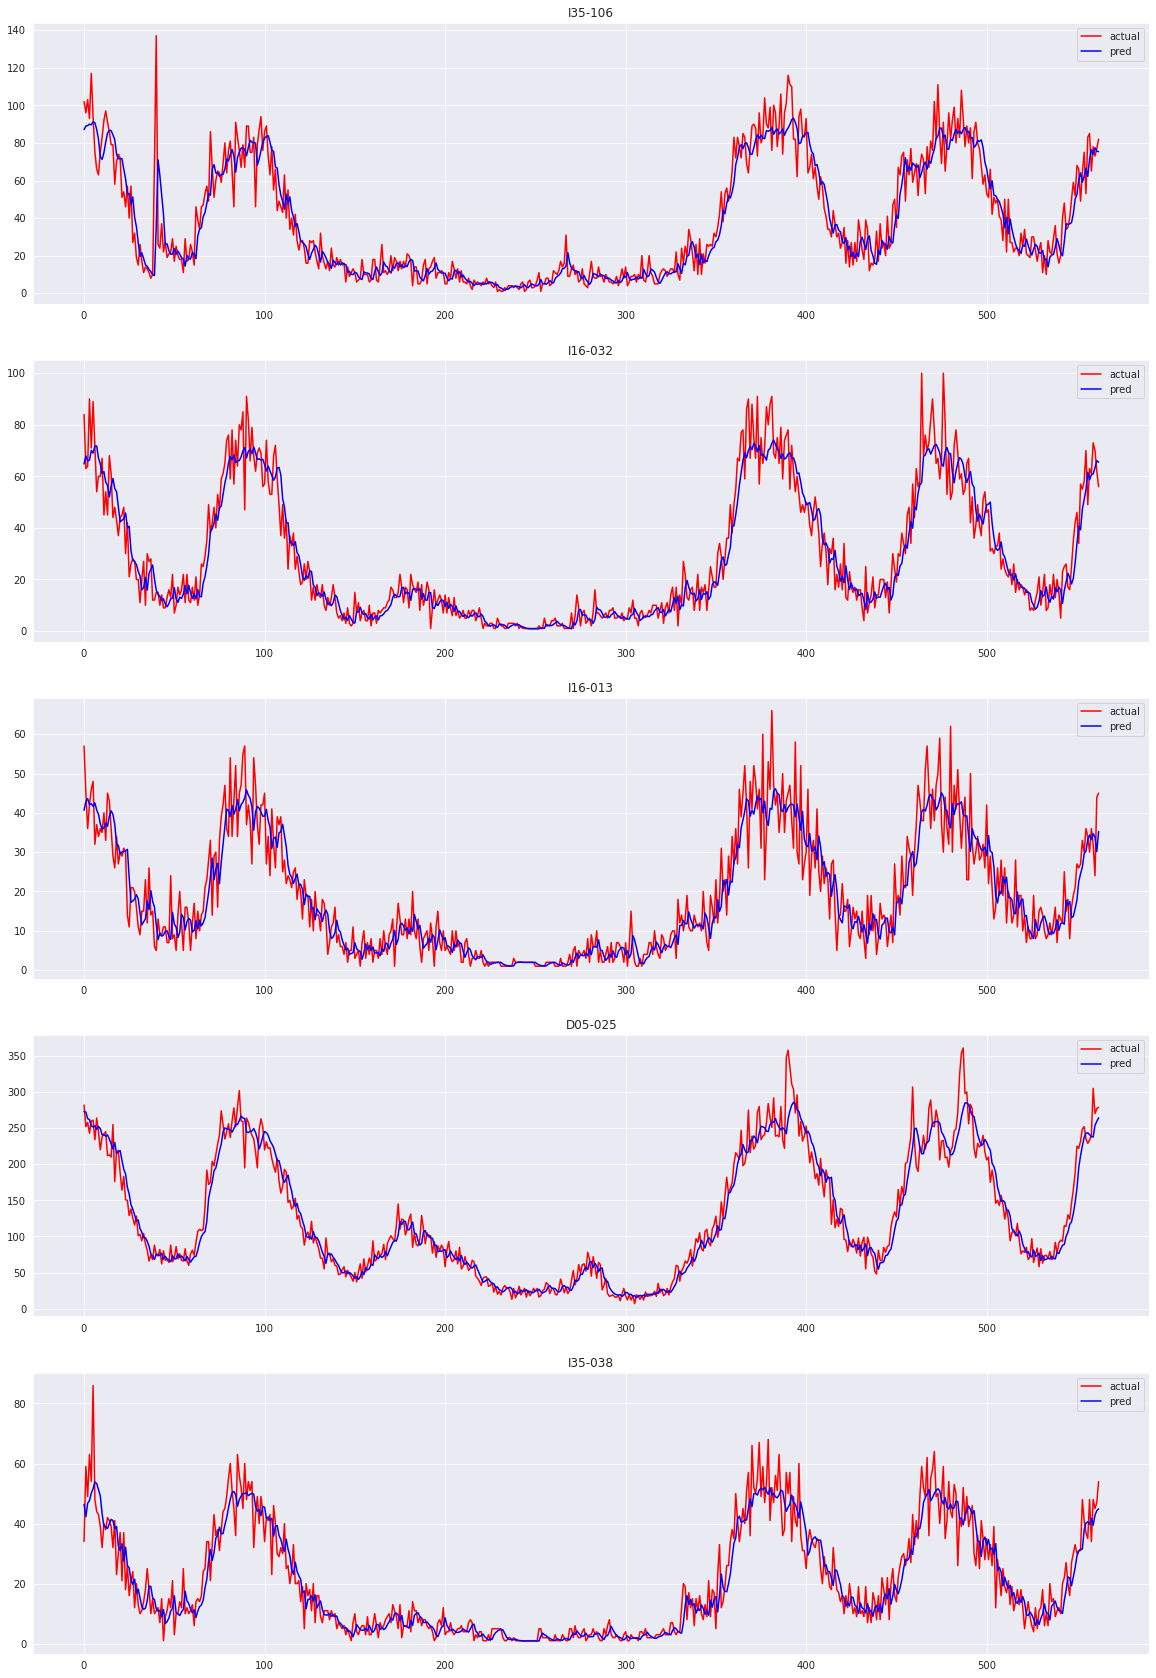

In [56]:
class LSTM_Model(nn.Module):
    def __init__(self, encoder_length=14, in_channels=1, hidden_size=16, num_layers=2, bidirectional=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.window = encoder_length
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.rnn = nn.LSTM(input_size=self.in_channels, hidden_size=self.hidden_size, num_layers=self.num_layers,
            batch_first=True, bidirectional=self.bidirectional)
        self.rnn.flatten_parameters()
        self.lin = nn.Linear(self.hidden_size * 2 if self.bidirectional else 1, 1)
    
    def forward(self, X, *args, **kwargs):
        X = X.transpose(1, 2)
        batch_size = len(X)
        nodes_num = X.shape[1]
        X = X.reshape(-1, self.window, self.in_channels)
        out, (hn, cn) = self.rnn(X)
        out = out[:, -1, :]
        out = out.reshape(batch_size, nodes_num, -1)
        out = self.lin(out)
        return out

model = LSTM_Model(encoder_length=4, in_channels=1).to(device)
model = run(model, results, num_epochs=20, plot=True, plot_update_freq=2)
evaluate_plot(model, test_loader, scaler)

**GNN + LSTM**

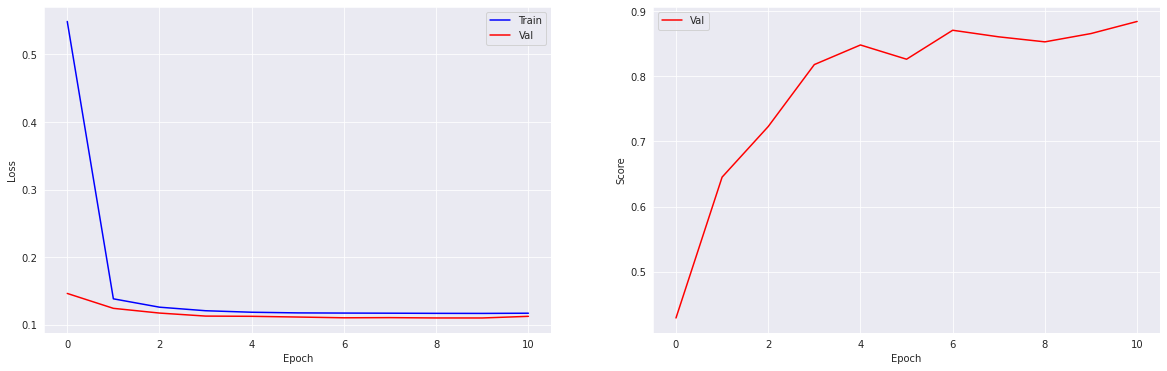

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/torch/nn/modules/rnn.py:762: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Type: GNN_LSTM_Model, Test loss: 0.11, Test score: 0.8794


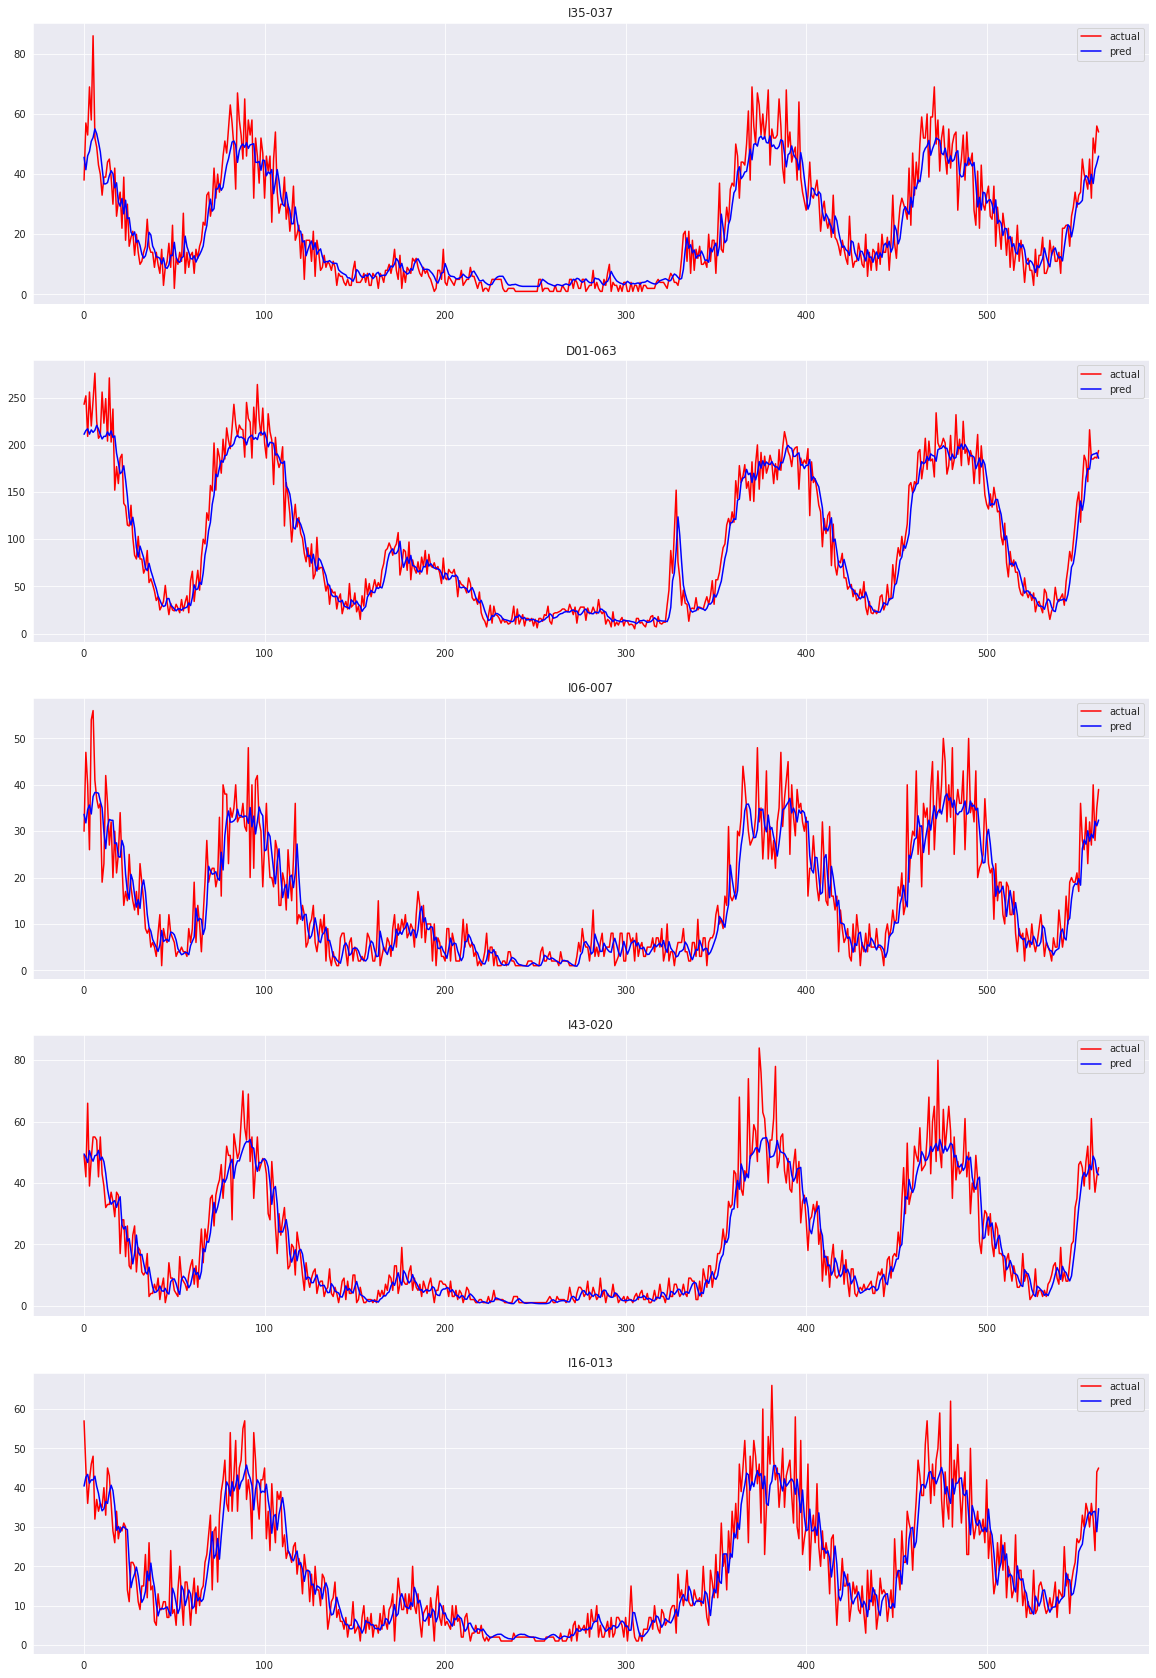

CPU times: user 1min 24s, sys: 169 ms, total: 1min 25s
Wall time: 1min 25s


In [24]:
%%time

class GNN_LSTM_Model(nn.Module):
    def __init__(self, encoder_length=14, in_channels=1, gnn_hidden_dim=8,
     lstmcell_hidden_size=16, lstm_num_layers=2, bidirectional=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.window = encoder_length
        
        self.gnn_hidden_dim = gnn_hidden_dim
        self.graph_layer = GCNConv(self.in_channels, self.gnn_hidden_dim)

        self.lstmcell_hidden_size = lstmcell_hidden_size
        self.lstm_num_layers = lstm_num_layers
        self.bidirectional = bidirectional
        self.rnn = nn.LSTM(input_size=self.gnn_hidden_dim, hidden_size=self.lstmcell_hidden_size, 
            num_layers=self.lstm_num_layers, batch_first=True, bidirectional=self.bidirectional)

        self.lin = nn.Linear((2 if self.bidirectional else 1) * self.lstmcell_hidden_size, 1)
    
    def forward(self, X, edge_index, *args, **kwargs):
        """X has shape [N, window, nodes_num, in_channels]
        edge_index has shape [N, 2, edges_num]

        Args:
            X (torch.Tensor): batched input features
            edge_index (torch.Tensor): adj list 

        Returns:
            torch.Tensor: predictions
        """
        
        batch_size = X.shape[0]
        nodes_num = X.shape[2]

        X = X.reshape(-1, nodes_num, self.in_channels)
        out = torch.stack([self.graph_layer(X[snap], edge_index[snap // self.window]) for snap in range(len(X))])
        # out = self.graph_layer(X, edge_index[0])
        out = out.reshape(batch_size, self.window, nodes_num, self.gnn_hidden_dim)

        out = out.transpose(1, 2)
        out = out.reshape(-1, self.window, self.gnn_hidden_dim)
        
        out, (hn, cn) = self.rnn(out)
        out = out[:, -1, :]
        out = out.reshape(batch_size, nodes_num, -1)
        out = self.lin(out)
        return out

model = GNN_LSTM_Model(encoder_length=4, in_channels=1).to(device)
model = run(model, results, num_epochs=10, plot=True, plot_update_freq=2)
evaluate_plot(model, test_loader, scaler)

**GNN + LSTM**

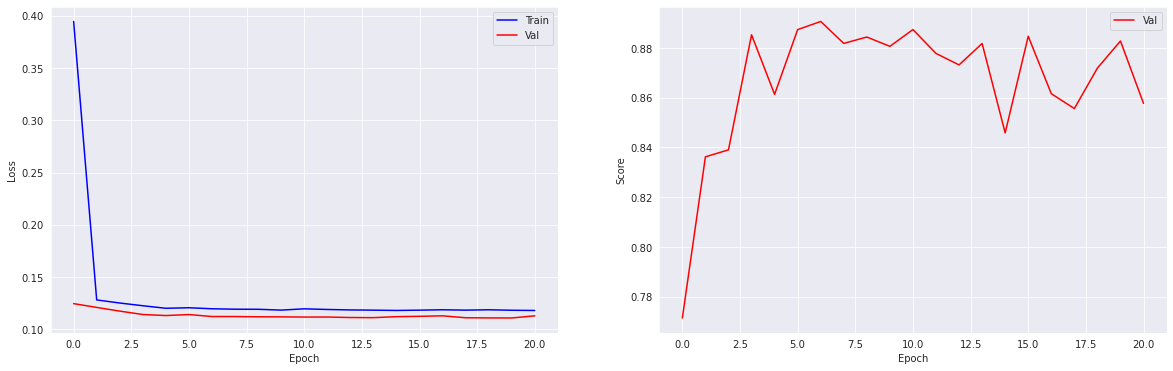

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/torch/nn/modules/rnn.py:762: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Type: LSTM_GNN_Model, Test loss: 0.11, Test score: 0.8859


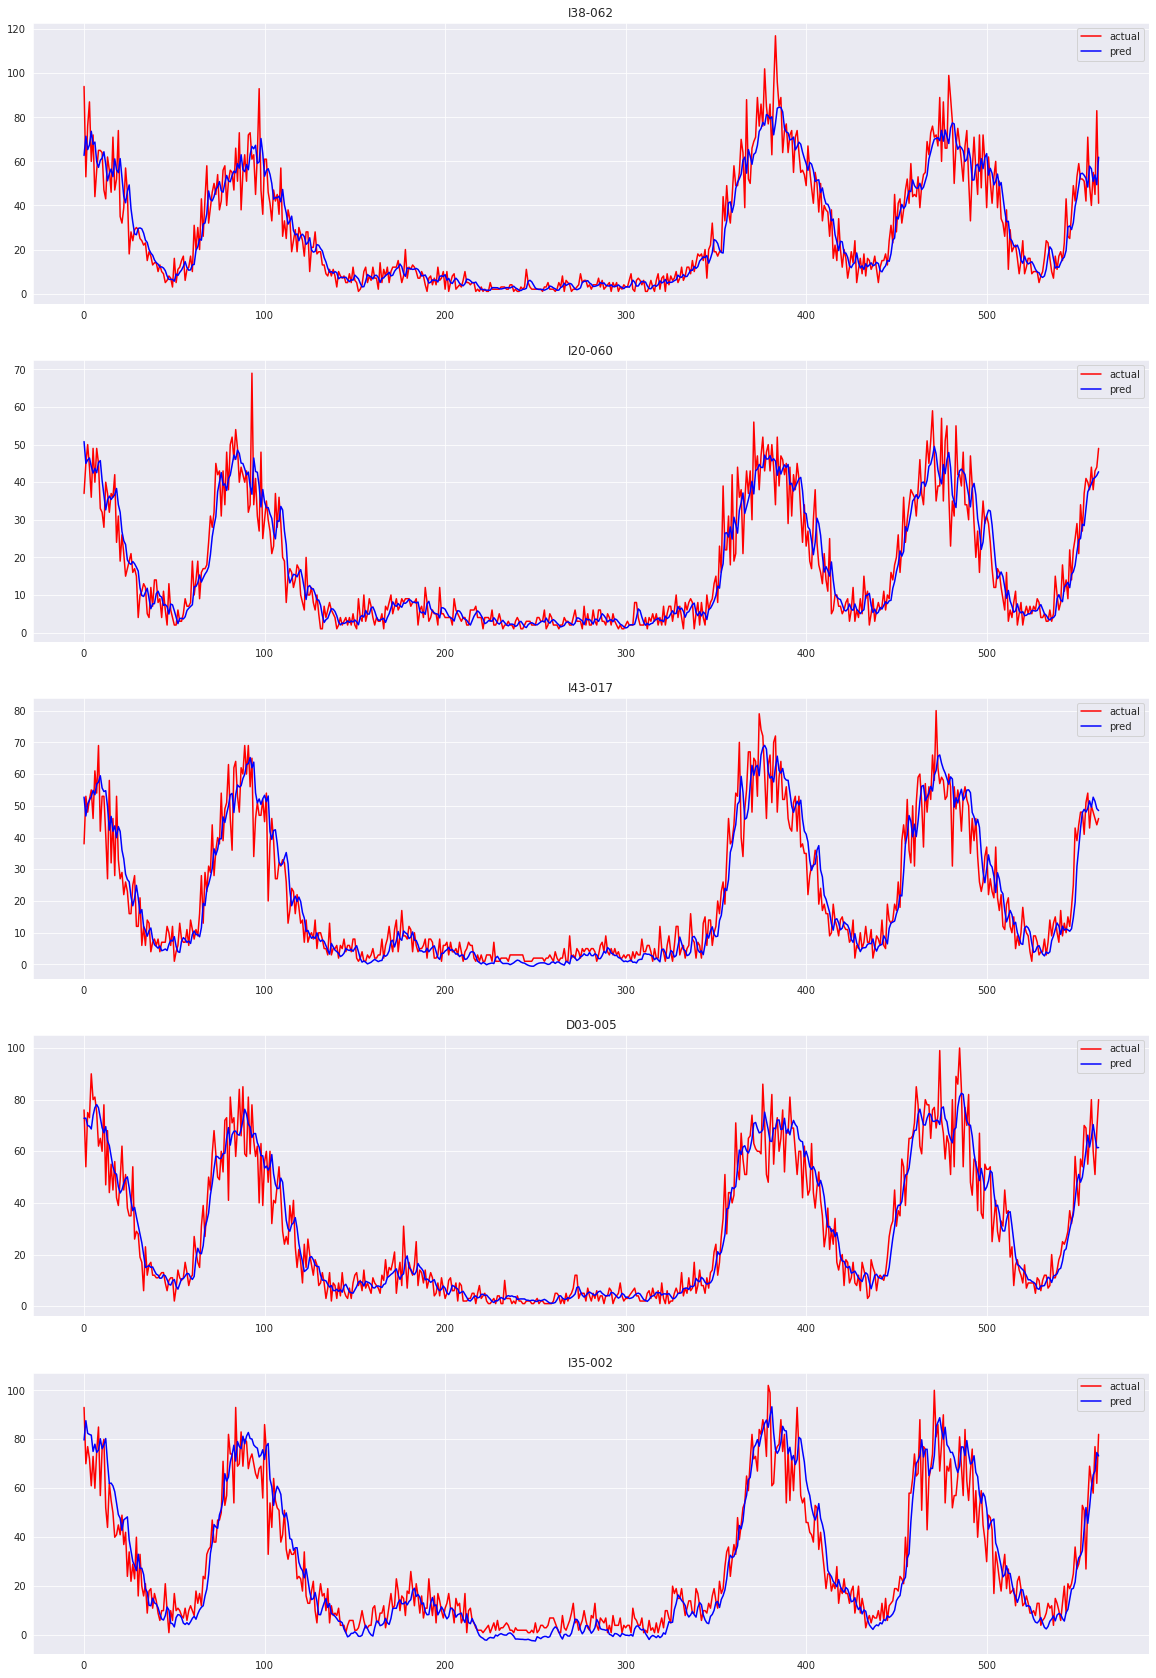

CPU times: user 1min 18s, sys: 249 ms, total: 1min 18s
Wall time: 1min 19s


In [23]:
%%time

class LSTM_GNN_Model(nn.Module):
    def __init__(self, encoder_length=14, in_channels=1, gnn_hidden_dim=32,
     lstmcell_hidden_size=32, lstm_num_layers=2, bidirectional=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.window = encoder_length
        

        self.lstmcell_hidden_size = lstmcell_hidden_size
        self.lstm_num_layers = lstm_num_layers
        self.bidirectional = bidirectional
        self.rnn = nn.LSTM(input_size=self.in_channels, hidden_size=self.lstmcell_hidden_size, 
            num_layers=self.lstm_num_layers, batch_first=True, bidirectional=self.bidirectional)

        self.gnn_hidden_dim = gnn_hidden_dim
        self.graph_layer = GCNConv((2 if self.bidirectional else 1) * self.lstmcell_hidden_size,
             self.gnn_hidden_dim)
        self.lin = nn.Linear(self.gnn_hidden_dim, 1)
    
    def forward(self, X, edge_index, *args, **kwargs):
        """X has shape [N, window, nodes_num, in_channels]
        edge_index has shape [N, 2, edges_num]

        Args:
            X (torch.Tensor): batched input features
            edge_index (torch.Tensor): adj list 

        Returns:
            torch.Tensor: predictions
        """
        
        batch_size = X.shape[0]
        nodes_num = X.shape[2]

        X = X.transpose(1, 2)

        X = X.reshape(batch_size * nodes_num, self.window, -1)

        out, _ = self.rnn(X)
        out = out[:, -1, :]
        out = out.reshape(batch_size, nodes_num, -1)
        out = torch.stack([self.graph_layer(out[snap], edge_index[snap]) for snap in range(len(out))])
        out = self.lin(out)
        return out


        # X = X.reshape(-1, nodes_num, self.in_channels)
        # out = torch.stack([self.graph_layer(X[snap], edge_index[snap // self.window]) for snap in range(len(X))])
        # # out = self.graph_layer(X, edge_index[0])
        # out = out.reshape(batch_size, self.window, nodes_num, self.gnn_hidden_dim)

        # out = out.transpose(1, 2)
        # out = out.reshape(-1, self.window, self.gnn_hidden_dim)
        
        # out, (hn, cn) = self.rnn(out)
        # out = out[:, -1, :]
        # out = out.reshape(batch_size, nodes_num, -1)
        # out = self.lin(out)
        # return out

model = LSTM_GNN_Model(encoder_length=4, in_channels=1).to(device)
model = run(model, results, num_epochs=20, plot=True, plot_update_freq=2)
evaluate_plot(model, test_loader, scaler)

**Linear Model + Time Features**

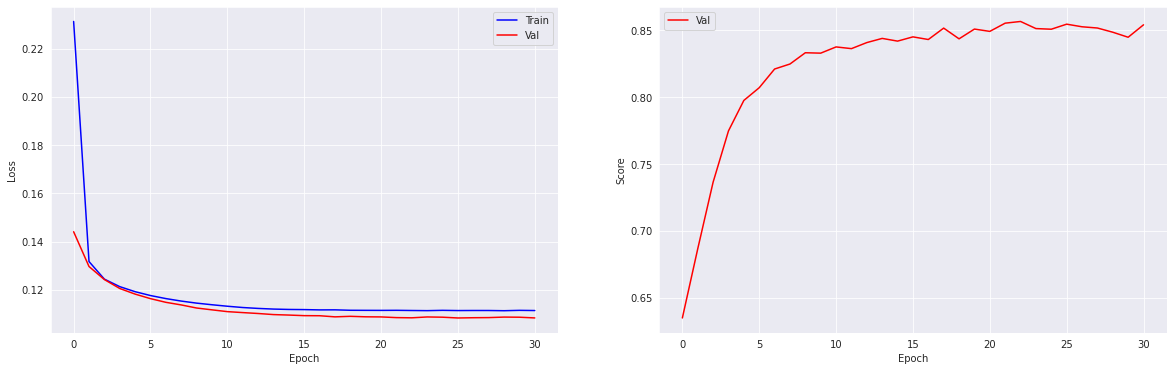

Type: LinearWithExtraFeaturesModel, Test loss: 0.10, Test score: 0.8516


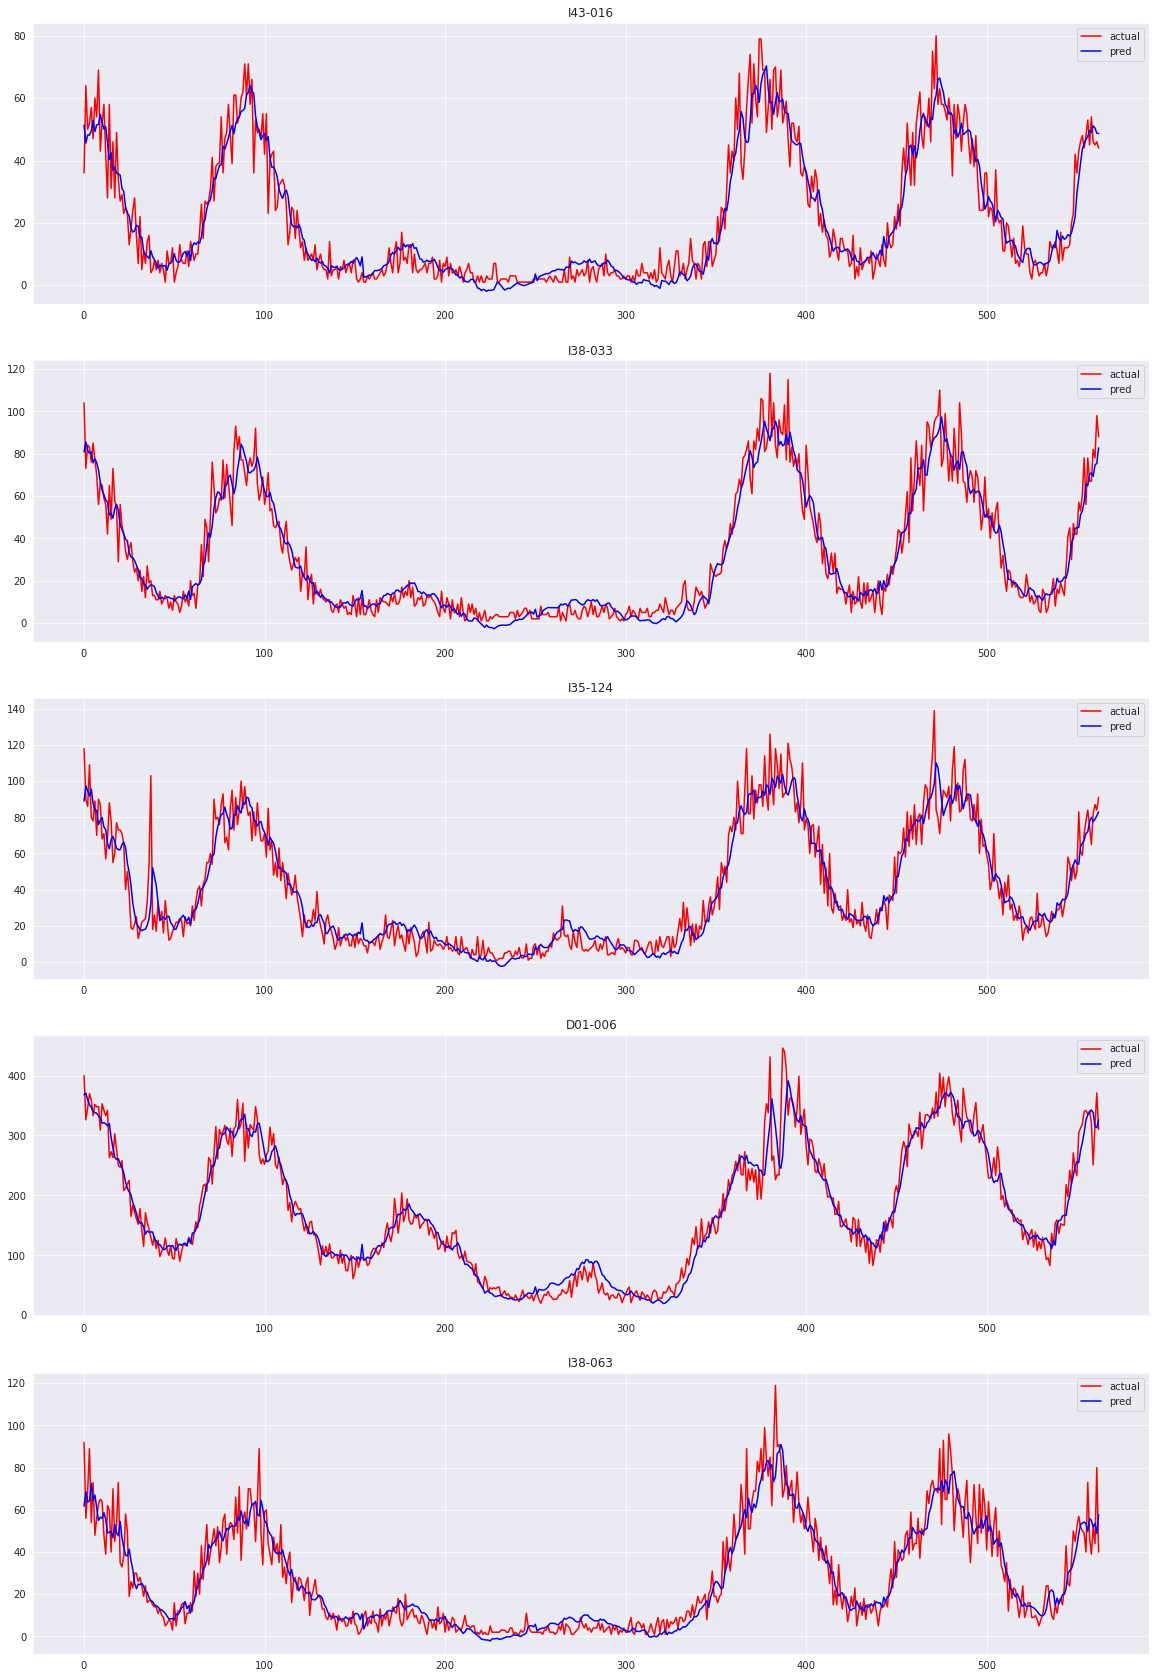

In [ ]:
class LinearWithExtraFeaturesModel(nn.Module):
    def __init__(self, encoder_length=14, in_channels=1, extra_channels=5, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.window = encoder_length
        self.in_channels = in_channels
        self.extra_channels = extra_channels
        self.lin = nn.Linear(self.window * (self.in_channels + extra_channels), 1)
    
    def forward(self, X, X_extra, *args, **kwargs):
        X = X.transpose(1, 2)
        batch_size = X.shape[0]
        nodes_num = X.shape[1]
        # print(X.shape, X_extra.shape)
        X_extra = X_extra.unsqueeze(-1).expand(-1, -1, -1, nodes_num).permute(0, 3, 1, 2)
        X = torch.cat((X, X_extra), dim=-1)
        X = X.reshape(batch_size, nodes_num, -1)
        out = self.lin(X)
        return out

model = LinearWithExtraFeaturesModel(encoder_length=4, in_channels=1).to(device)
model = run(model, results, num_epochs=30, plot=True, plot_update_freq=5)
evaluate_plot(model, test_loader, scaler)

**LSTM + Time Features**

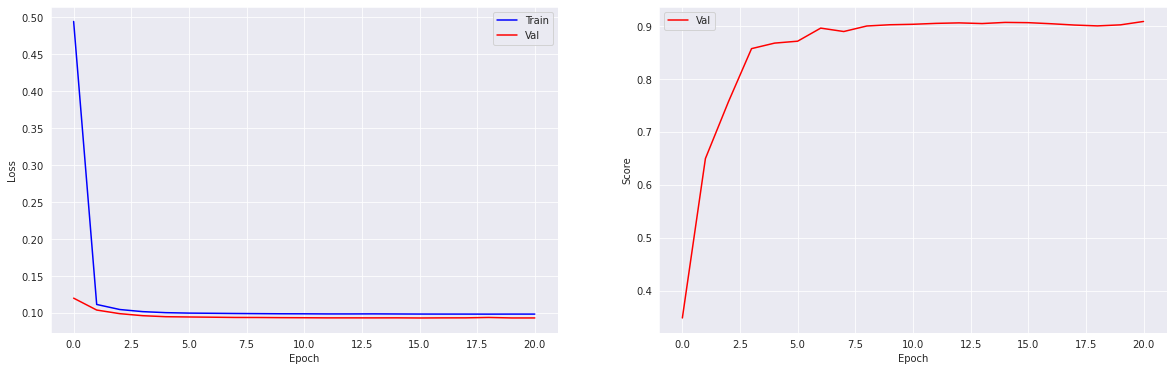

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/torch/nn/modules/rnn.py:762: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


Type: LSTMWithExtraFeaturesModel, Test loss: 0.09, Test score: 0.9043


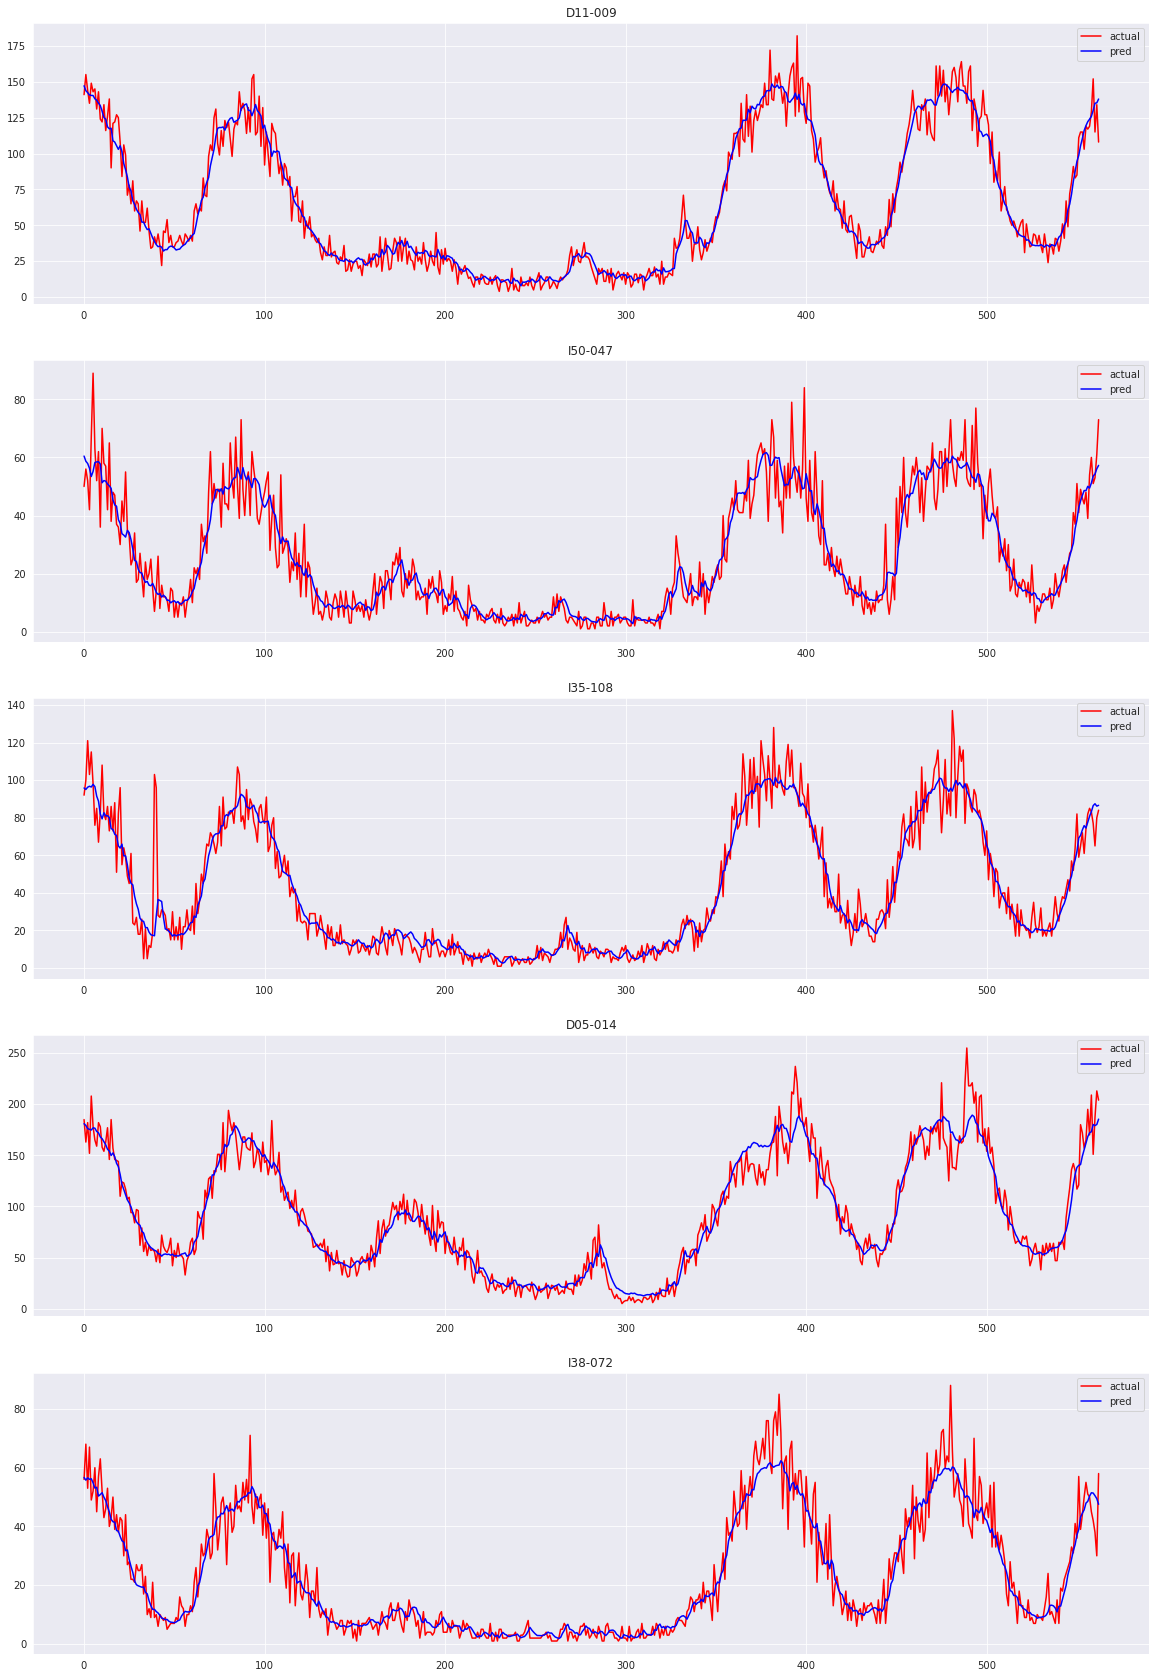

In [ ]:
class LSTMWithExtraFeaturesModel(nn.Module):
    def __init__(self, encoder_length=14, in_channels=1, extra_channels=5,
      hidden_size=16, num_layers=2, bidirectional=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.extra_channels = extra_channels
        self.window = encoder_length
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.rnn = nn.LSTM(input_size=(self.in_channels + self.extra_channels), 
          hidden_size=self.hidden_size, num_layers=self.num_layers,
            batch_first=True, bidirectional=self.bidirectional)
        self.rnn.flatten_parameters()
        self.lin = nn.Linear(self.hidden_size * 2 if self.bidirectional else 1, 1)
    
    def forward(self, X, X_extra, *args, **kwargs):
        X = X.transpose(1, 2)
        batch_size = len(X)
        nodes_num = X.shape[1]
        # print(X.shape, X_extra.shape)
        X_extra = X_extra.unsqueeze(-1).expand(-1, -1, -1, nodes_num).permute(0, 3, 1, 2)
        X = torch.cat((X, X_extra), dim=-1)
        X = X.reshape(-1, self.window, self.in_channels + self.extra_channels)
        out, (hn, cn) = self.rnn(X)
        out = out[:, -1, :]
        out = out.reshape(batch_size, nodes_num, -1)
        out = self.lin(out)
        return out

model = LSTMWithExtraFeaturesModel(encoder_length=4, in_channels=1).to(device)
model = run(model, results, num_epochs=20, plot=True, plot_update_freq=5)
evaluate_plot(model, test_loader, scaler)

In [ ]:
import json
with open('results.json', mode='w') as f:
    json.dump(results, f, indent=4)